# 1. Implementing node2vec

Write a function to simulate a random walks of length l utilizing the algorithm provided in node2vec paper with parameters p and q.  

In [59]:
#imports:
import numpy as np
import networkx as nx
import gensim
from gensim.models.word2vec import Word2Vec

In [60]:
#test values:

p = 1
q = 0.5
l = 2
s = '1'
G = nx.Graph()
G.add_edges_from([('1','2'),('1','3'),('2','3'),('2','4'),('2','5')])
k = 3
d = 128

In [61]:
def biasedRandomWalk(Graph = G, length = l,p = p, q = q, start_node=s):
    
    walk = []
    former_node = start_node
    walk.append(former_node)
    node = np.random.choice(list(Graph.neighbors(start_node)))
    walk.append(node)

    for i in range(length):
            
        probabilities = dict()
        probabilities[former_node] = 1/p
        
        for node2 in Graph.neighbors(node):
                if (former_node, node2) in Graph.edges:
                    probabilities[node2] = 1
                else:
                    probabilities[node2] = 1/q
        
        
        summ = sum(probabilities.values())
        
        for key in probabilities:
            probabilities[key] /= summ
        
        former_node = node
        node = np.random.choice(list(probabilities), p = list(probabilities.values()))
        
        walk.append(node)
        
    # generated walk considering start_node s
    
    return walk    
# when storing the visited nodes in the list walk, store them as stings rather than int as gensim allows 
# only string inputs which you will use subsequently
# e.g., walk = ['1','2','4',...] and not [1, 2, 4, ....]

biasedRandomWalk()

['1', '3', '1', '2']

Generate k random walks considering each node as the starting point of a walk. This means the number of generated walks should be of the order of the (Nk) where n is the number of nodes. 

In [62]:
def GenerateRandomWalks(Graph = G, length = l, p = p, q = q, num_walks=k):
    
    nodes = Graph.nodes # list of nodes in the graph
    all_walks = [biasedRandomWalk(Graph, length, p, q, start) for start in nodes for i in range(num_walks)]
    
    # walk = generate k walks for each node using the function biasedRandomWalk
    
    return all_walks

GenerateRandomWalks()

[['1', '3', '1', '3'],
 ['1', '2', '5', '2'],
 ['1', '2', '1', '2'],
 ['2', '3', '1', '3'],
 ['2', '1', '2', '1'],
 ['2', '3', '1', '2'],
 ['3', '2', '4', '2'],
 ['3', '2', '4', '2'],
 ['3', '1', '3', '1'],
 ['4', '2', '5', '2'],
 ['4', '2', '5', '2'],
 ['4', '2', '1', '2'],
 ['5', '2', '5', '2'],
 ['5', '2', '3', '1'],
 ['5', '2', '4', '2']]

Considering these generated random walks as sentences utilize the word2vec function in gensim to obtain embeddings of the nodes. 

In [63]:
def generateEmbeddings(all_walks,dimension = d, min_count=1):
    
    model = Word2Vec(all_walks, size=d, min_count = min_count)
    # generate embeddings using word2vec

    return model

Consider the bible network (bible_names_incomp.txt) where nodes represent proper nouns and an edge occurs between two nodes if they coocur in a sentence. Obtain embeddings for the nodes using the functions implemented before. The parameters are - 
1. length = 10
2. p = 1
3. q = 0.5
4. k (number of walks for each node) = 5
5. dimension of embedding d = 128

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


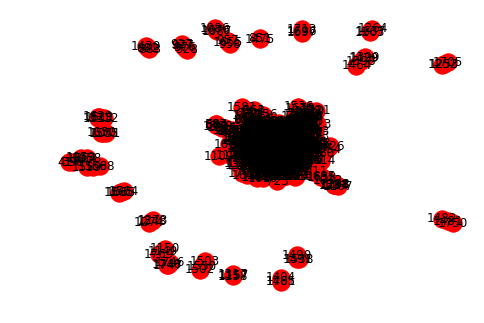

In [64]:
# note : You may use networkx to represent the graph

f = open("bible_names_incomp.txt", "r")

edges = [tuple(line.replace("\n", "").split(" ")) for line in f]

G = nx.Graph()
G.add_edges_from(edges)


mod = generateEmbeddings(GenerateRandomWalks(G,length = 10, p = 1, q = 0.5, num_walks = 5), dimension = 128)

nx.draw(G, size = 10, pos=nx.spring_layout(G), with_labels = True) 

# 2. Link prediction using representations

The network provided above consists only of 80 percent of all the edges present in the network. The whole network is available in the file Bible_names.txt. 

Find out the edges which are missing in the incomplete network.


In [65]:
G = nx.read_edgelist('bible_names.txt')
Gi = nx.read_edgelist('bible_names_incomp.txt')

In [67]:
def missing_edges(G_complete, G_missing):
    m_edges = []
    for edge in G_complete.edges():
        if edge not in G_missing.edges():
            m_edges.append(edge)
    # obtain the missing edges and put them in m_edges.. edge should be represented as a tuple (u,v)
    return m_edges
print('There are {} missing edges'.format(len(missing_edges(G, Gi))))

There are 1826 missing edges


For every pair of vertices (u,v) in the incomplete network which are not connected by an edge, calculate the cosine similarity between the embedding of u and embedding of v.

In [71]:
import itertools 
from scipy import spatial
#from gensim.models.word2vec import Word2Vec
def similarityNodes(G_missing):
    not_connected = []
    for f in range(1, len(list(G_missing.nodes()))-1):
        for s in range(f+1,len(list(G_missing.nodes()))):
            if str(s) not in list(G_missing.neighbors(str(f))):
                not_connected.append(tuple([str(f), str(s)]))
    mod = generateEmbeddings(GenerateRandomWalks(G_missing,length = 10, p = 1, q = 0.5, num_walks = 5), dimension = 128)
    similarity = {}
    for pair in not_connected:
        similarity[tuple([pair[0],pair[1]])] = 1 - spatial.distance.cosine(mod.wv[pair[0]],mod.wv[pair[1]])
    return similarity
#imilarityNodes(Gi)

Rank all these pairs based on the similarity score.

In [72]:
def obtainRankedPairs(similarity):
    ranked_pairs = [pair for pair, score in similarity.items() if score>0.97] 
    return ranked_pairs
similarity = similarityNodes(Gi)
ranks = obtainRankedPairs(similarity)

# Precision @ k

Calculate the precision at k for the link prediction task. To elaborate, consider the ranked list you obtained in the last step of the previos task. Now start from the first element in the list. If the vertex pair is indeed an edge in the network, then precision @ 1 = 1/1 = 1, now lets say the second element is not an edge in the original network, then precision @ 2 = (1+0)/2 = 0.5 and so on. You should continue to k = number of missing edges. 

In [73]:
def calculatePrecisionk(ranked_pairs,m_edges):
    tmp = 0
    precision = []
    # calculate precision values from k = 1 to len(m_edges)
    for i in range(1, len(m_edges)):
        if ranked_pairs[i] in m_edges:
            tmp += 1
            precision.append(tmp/i)
        else:
            precision.append(tmp/i)
    return precision

m_edges = missing_edges(G, Gi)
precision = calculatePrecisionk(ranks,m_edges)
#print(precision)

Plot a graph with x-axis as k (1 to the number of missing edges) and y-axis as the precision value @k

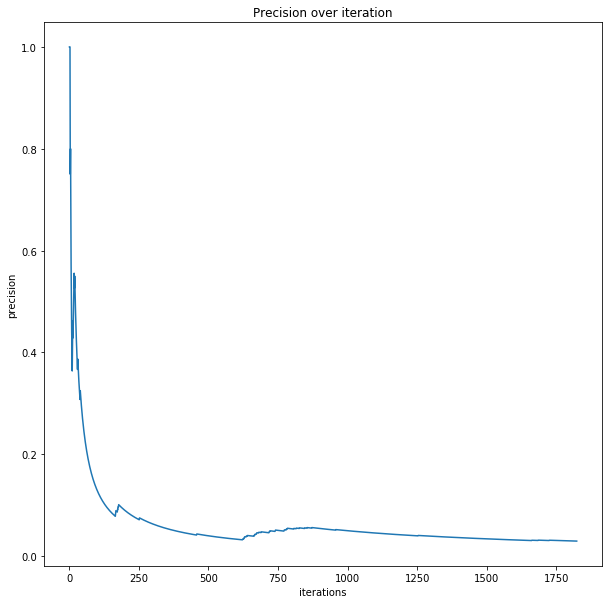

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
def plotPrecision(precision):
    plt.figure(figsize=(10,10))
    plt.plot(range(len(precision)), precision)
    plt.title('Precision over iteration')
    plt.xlabel('iterations')
    plt.ylabel('precision')
    
plotPrecision(precision)
    